# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [1]:
!pip install --upgrade --user cvxopt

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers
from cvxopt import matrix
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_circles
from sklearn.preprocessing import PolynomialFeatures
solvers.options['show_progress'] = False

In [3]:
# Define QP parameters (directly)
P = matrix(np.array([[2,0],[0,8]]), tc='d')
q = matrix(np.array([-8,-16]), tc='d')
G = matrix(np.array([[-1,0],[1,0],[0,-1],[1,1]]), tc='d')
h = matrix(np.array([0,3,0,5]), tc='d')

sol = solvers.qp(P,q,G,h)

print(sol['x'])
print(sol['primal objective'])

[ 3.00e+00]
[ 2.00e+00]

-30.99999280553902


## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

**Реализуем алгоритм SVM, пока что с линейным ядром**

In [42]:
class SVM:
    def __init__(self):
        self.l = 0
        self.n = 0
        self.P = 0
        self.w = 0
        self.w0 = 0
        self.lmbda = 0
    def ker(self, x1, x2):
        return np.dot(x1, x2)
    def fit(self, X, y, C):
        self.l = X.shape[0]
        self.n = X.shape[1]
        self.X = X.copy()
        self.y = y.copy()
        
        Pnp = np.zeros((self.l, self.l))
        for i in range(self.l):
            for j in range(self.l):
                Pnp[i][j] = y[i] * y[j] * self.ker(X[i], X[j])
        P = matrix(Pnp, tc='d')

        q = matrix(np.ones(self.l) * -1, tc='d')
        G = matrix(np.concatenate((np.eye(self.l) * -1, np.eye(self.l))), tc='d')
        h = matrix(np.concatenate((np.zeros((self.l, 1)), np.zeros((self.l, 1)) + C)), tc='d')
        A = matrix(np.reshape(y, (1, self.l)), tc='d') #НЕ ЗАБЫТЬ ПОФИКСИТЬ СТРАННОЕ
        b = matrix(0, tc='d')
        
        sol = solvers.qp(P, q, G, h, A, b)
        
        self.lmbda = (np.array(sol['x'])).flatten()
        self.w = np.matmul(self.lmbda * y, X)
        
        support_X = X[np.where(self.lmbda > 1e-5)]
        support_y = y[np.where(self.lmbda > 1e-5)]
        self.w0 = np.dot(self.w, support_X[0]) - support_y[0]
        
        return self
    def predict(self, x):
        #В ядровом SVM сделать предикт как в формуле (1.8), не переходить от лямбда к w
        return np.sign(np.dot(x, self.w) - self.w0)
    def predict_proba(self, X):
        return np.dot(X, self.w) - self.w0
    
#     def show_results(self, X, y, n_points=100):
#         xvals = np.linspace(-2, 3, n_points)
#         yvals = np.linspace(-2, 3, n_points)

#         xx, yy = np.meshgrid(xvals, yvals)
#         z = np.zeros((n_points, n_points))
#         for i in range(n_points):
#             for j in range(n_points):
#                 z[i][j] = self.predict_proba(np.array([xx[i,j], yy[i,j]]))

#         plt.pcolormesh(xx, yy, z)
#         plt.contour(xx, yy, z, levels=[-1,0,1], colors=['black'])
#         plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

    def show_results(self, ax, n_points=100):
        xvals = np.linspace(-2, 3, n_points)
        yvals = np.linspace(-2, 3, n_points)

        xx, yy = np.meshgrid(xvals, yvals)
        z = np.zeros((n_points, n_points))
        for i in range(n_points):
            for j in range(n_points):
                z[i][j] = self.predict_proba(np.array([xx[i,j], yy[i,j]]))

        ax.pcolormesh(xx, yy, z)
        ax.contour(xx, yy, z, levels=[-1,0,1], colors=['black'])
        #ax.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='autumn', edgecolor='black')

**Проверим работу этого алгоритма**

1.500000008793751


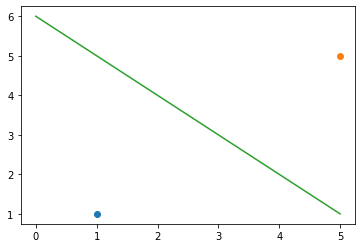

In [5]:
X = np.array([[1,1],[5,5]])
y = np.array([-1, 1])
sv = SVM().fit(X, y, 1)
OX = np.linspace(0, 5, 3)
# print(sv.w)
print(sv.w0)
OY = (-sv.w[0]/sv.w[1]*OX + sv.w0/sv.w[1])
plt.plot(X[0][0], X[0][1], marker='o')
plt.plot(X[1][0], X[1][1], marker='o')
plt.plot(OX, OY)
# print(sv.predict([10,10]))
# print(sv.w)
#print(np.where(sv.lmbda > 1e-5))

**Создадим случайные выборки**

In [6]:
X_l_sep, y_l_sep = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
y_l_sep[np.where(y_l_sep == 0)[0]] = -1
#plt.scatter(X_l_sep[:, 0], X_l_sep[:, 1], c=y_l_sep, cmap='autumn', edgecolor='black')

In [7]:
X_circle, y_circle = make_circles(n_samples=100, random_state=1)
y_circle[np.where(y_circle == 0)[0]] = -1
#plt.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle, cmap='autumn', edgecolor='black')

In [8]:
X_moon, y_moon = datasets.make_moons(n_samples=100, random_state=10)
y_moon[np.where(y_moon == 0)[0]] = -1
#plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap='autumn', edgecolor='black')

In [9]:
X_n_sep, y_n_sep = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, class_sep = 0.1, random_state=1)
y_n_sep[np.where(y_n_sep == 0)[0]] = -1
#plt.scatter(X_n_sep[:, 0], X_n_sep[:, 1], c=y_n_sep, cmap='autumn', edgecolor='black')

**Протестируем наш метод на сгенерированных выборках**

**Начнем исследование с линейно разделимой выборки. Для начала построим красивую разделяющую прямую и покажем опорные вектора**

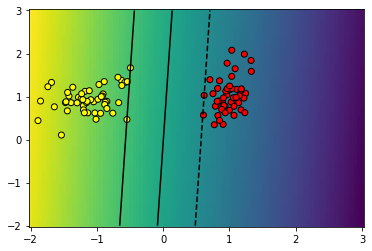

In [10]:
svm = SVM().fit(X_l_sep, y_l_sep, 1000)
svm.show_results(X_l_sep, y_l_sep)

**ОНО РАБОТАЕТ**

**Теперь попробуем переиграть нелинейно разделимый случай**

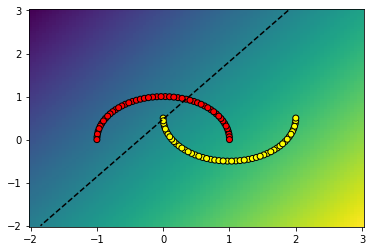

In [11]:
svm = SVM().fit(X_moon, y_moon, 0.001)
svm.show_results(X_moon, y_moon)

**Теперь попробуем неразделимый случай**

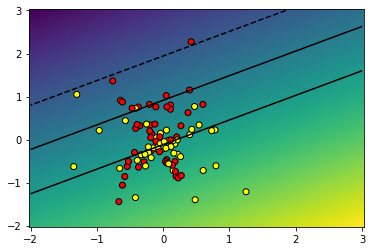

In [12]:
svm = SVM().fit(X_n_sep, y_n_sep, 1)
svm.show_results(X_n_sep, y_n_sep)

**Теперь, используя явное преобразование, обучим квадратичную разделяющую поверхность**

In [16]:
def hyperplane(w, x, b):
    result = 0
    for i in range(len(w)-1):
        result -= w[i] * x[i]
    result /= w[-1] + np.pow(10, -10)
    return result

def square_transform(X):
    poly = PolynomialFeatures(2)
    X_new = poly.fit_transform(X)
    X_new = X_new[:,1:]
    
    return X_new

def cube_transform(X):
    poly = PolynomialFeatures(3)
    X_new = poly.fit_transform(X)
    X_new = X_new[:,1:]
    
    return X_new

ValueError: shapes (2,) and (5,) not aligned: 2 (dim 0) != 5 (dim 0)

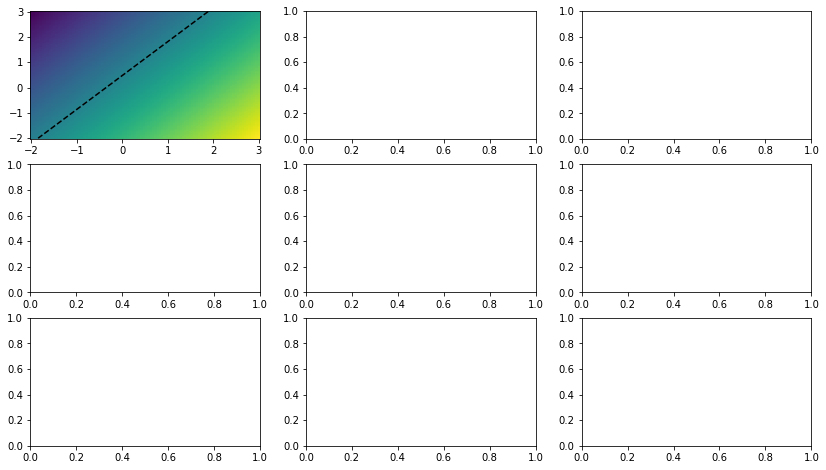

In [43]:
fig, ax = plt.subplots(3, 3, figsize=(14, 8))
square_moons = square_transform(X_moon)
cubic_moons = cube_transform(X_moon)

C = np.logspace(-3, 5, 3)

#ax[0, 2].scatter(X_moon[0,:], X_moon[1,:])

for i in range(3):
        svm = SVM()
        svm.fit(X_moon, y_moon, C[i])
        svm.show_results(ax[i,0])

        svm = SVM()
        svm.fit(square_moons, y_moon, C[i])
        svm.show_results(ax[i,1])

        svm = SVM()
        svm.fit(cubic_moons, y_moon, C[i])
        svm.show_results(ax[i,2])

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

**Создадим ядровой SVM**

In [38]:
class SVM_Ker:
    def __init__(self, C, k_type='linear', gamma=1, p_degree=2):
        self.C = C
        self.ker_type = k_type
        self.gamma = gamma
        self.p = p_degree
        
    def ker(self, x1, x2):
        if self.ker_type == 'linear':
            return np.dot(x1, x2)
        if self.ker_type == 'polynomial':
            return (np.dot(x1.T, x2) + 1)**self.p
        if self.ker_type == 'gaussian':
            return np.exp(-((np.linalg.norm(x1-x2))**2/(2*self.gamma)))
        
    def fit(self, X, y):
        self.l = X.shape[0]
        self.n = X.shape[1]
        self.y = y
        self.X = X.copy()
        
        Pnp = np.zeros((self.l, self.l))
        for i in range(self.l):
            for j in range(self.l):
                Pnp[i][j] = y[i] * y[j] * self.ker(X[i], X[j])
        P = matrix(Pnp, tc='d')
        
        q = matrix(np.ones(self.l) * -1, tc='d')
        G = matrix(np.concatenate((np.eye(self.l) * -1, np.eye(self.l))), tc='d')
        h = matrix(np.concatenate((np.zeros((self.l, 1)), np.zeros((self.l, 1)) + C)), tc='d')
        A = matrix(np.reshape(y, (1, self.l)), tc='d') #НЕ ЗАБЫТЬ ПОФИКСИТЬ СТРАННОЕ
        b = matrix(0, tc='d')
        
        sol = solvers.qp(P, q, G, h, A, b)
        
        self.lmbda = (np.array(sol['x'])).flatten()
        self.w = np.matmul(self.lmbda * y, X)
        
        support_X = X[np.where(self.lmbda > 1e-9)]
        support_y = y[np.where(self.lmbda > 1e-9)]
        s = 0
        for i in range(len(support_X)):
            s += self.ker(self.w, support_X[i]) - support_y[i]
        self.w0 = s / len(support_X)
        #self.w0 = self.ker(self.w, support_X[0]) - support_y[0]
        
        return self
    
    def predict(self, x):
        return np.sign(self.predict_proba(x))
    
    def predict_proba(self, x):
        ker_product_vec = np.empty(self.l)
        for i in range(self.l):
            ker_product_vec[i] = self.ker(self.X[i], x)
        return np.dot(self.lmbda*self.y, ker_product_vec) - self.w0
    
    def show_results(self, ax, n_points=100):
        xvals = np.linspace(-2, 3, n_points)
        yvals = np.linspace(-2, 3, n_points)

        xx, yy = np.meshgrid(xvals, yvals)
        z = np.zeros((n_points, n_points))
        for i in range(n_points):
            for j in range(n_points):
                z[i][j] = self.predict_proba(np.array([xx[i,j], yy[i,j]]))

        ax.pcolormesh(xx, yy, z)
        ax.contour(xx, yy, z, levels=[-1,0,1], colors=['black'])
        ax.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='autumn', edgecolor='black')
        if self.ker_type == 'gaussian':
            ax.set_title(f'C={self.C}, param={self.gamma}')
        elif self.ker_type == 'polynomial':
            ax.set_title(f'C={self.C}, param={self.p}')

**Протестируем работоспособность ядрового SVM на линейно разделимом случае**

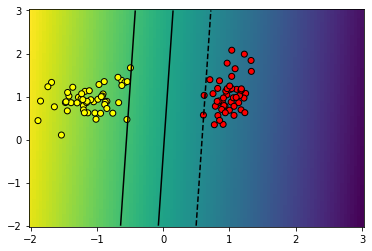

In [53]:
svm = SVM_Ker().fit(X_l_sep, y_l_sep, 4, k_type = 'linear')
svm.show_results()

**Посмотрим, как ведет себя полиноминальное ядро при различных значениях параметов С и p_degree**

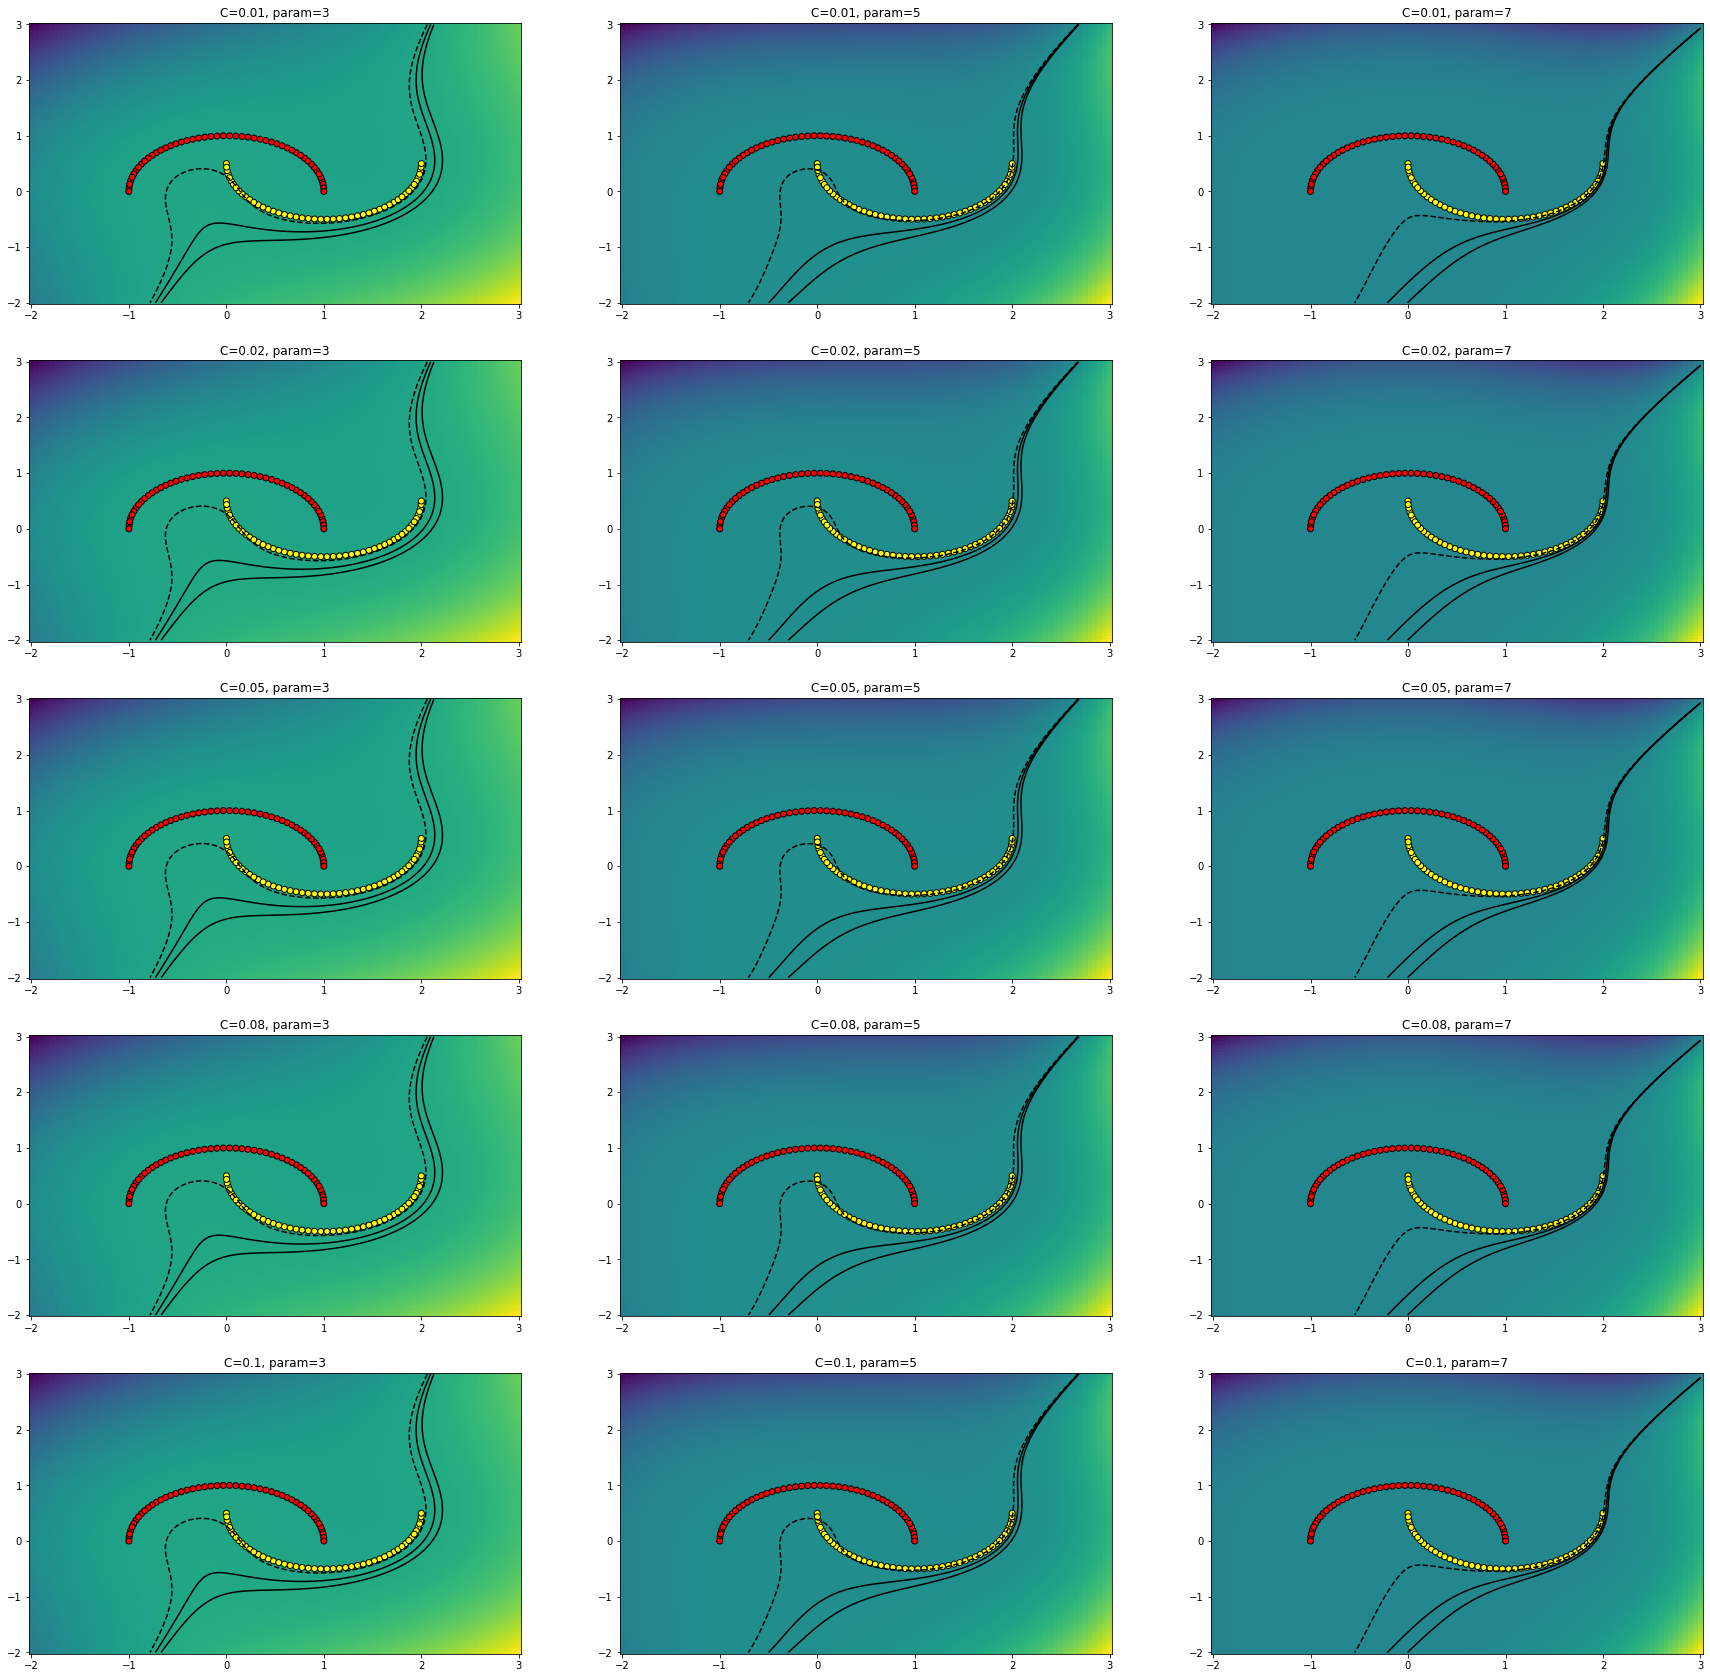

In [89]:
C_arr = np.array([0.01, 0.02, 0.05, 0.08, 0.1])
p_arr = np.array([3, 5, 7])

fig, axs = plt.subplots(len(C_arr), len(p_arr))
fig.set_figheight(30)
fig.set_figwidth(30)

for i in range(len(C_arr)):
    for j in range(len(p_arr)):
        svm = SVM_Ker(C_arr[i], k_type='polynomial', p_degree=p_arr[j])
        svm.fit(X_moon, y_moon)
        svm.show_results(axs[i, j])

**Полиноминальное ядро надо мной издевается, я не хочу его обсуждать**

**Теперь посмотрим, как ведет себя гауссово ядро при различных значениях параметра гамма и С**

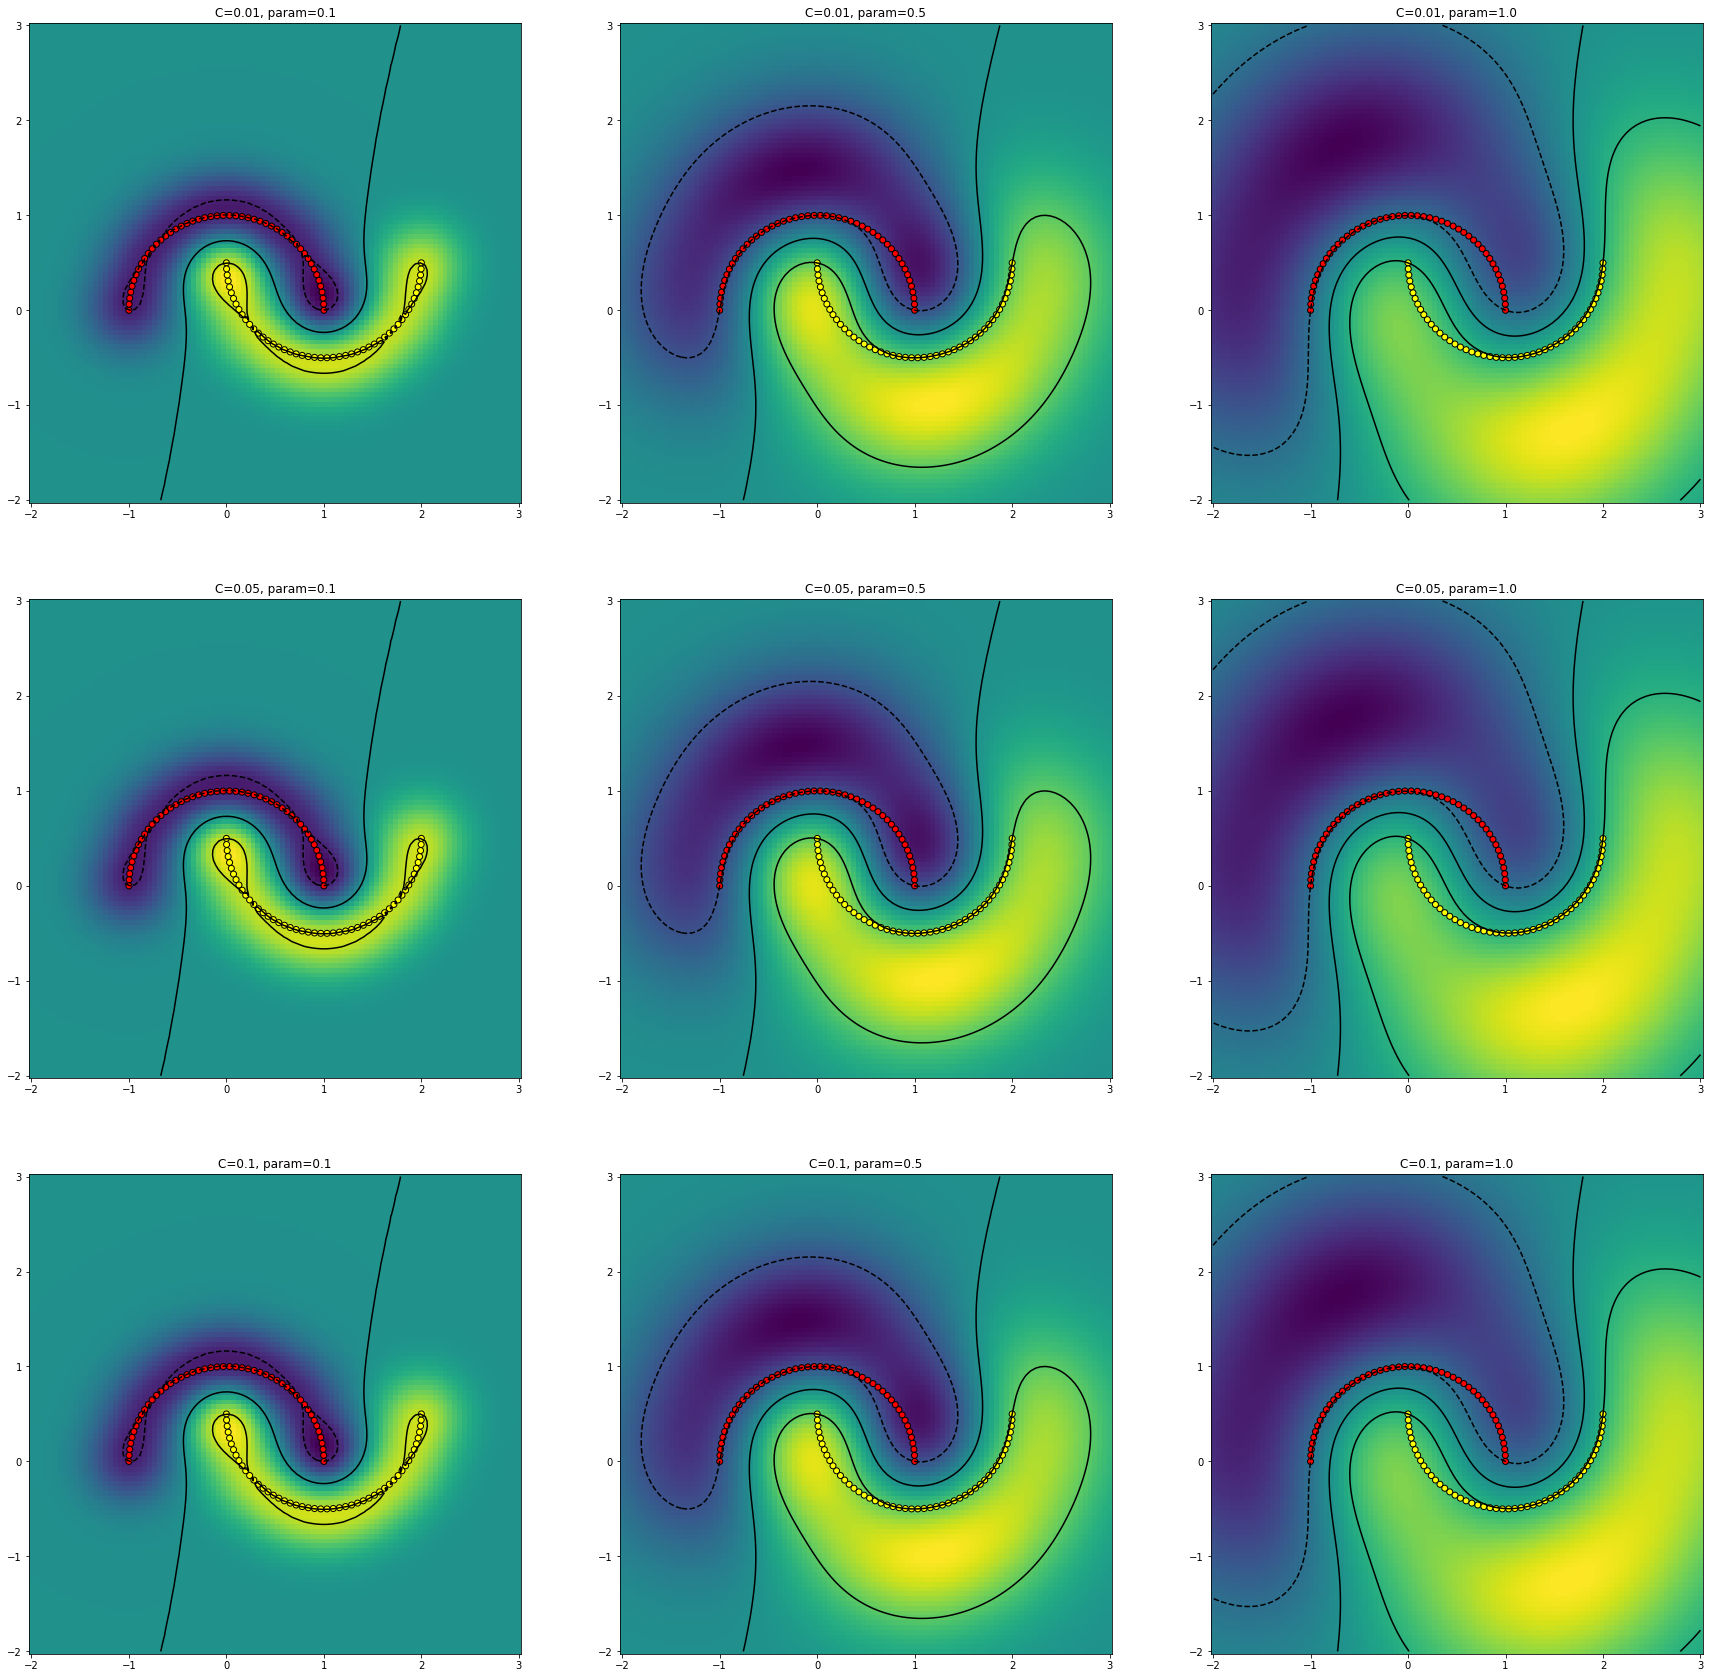

In [98]:
C_arr = np.array([0.01, 0.05, 0.1])
kappa_arr = np.array([0.1, 0.5, 1, 2])

fig, axs = plt.subplots(len(C_arr), len(p_arr))
fig.set_figheight(30)
fig.set_figwidth(30)

for i in range(len(C_arr)):
    for j in range(len(p_arr)):
        svm = SVM_Ker(C_arr[i], k_type='gaussian', gamma=kappa_arr[j])
        svm.fit(X_moon, y_moon)
        svm.show_results(axs[i, j])

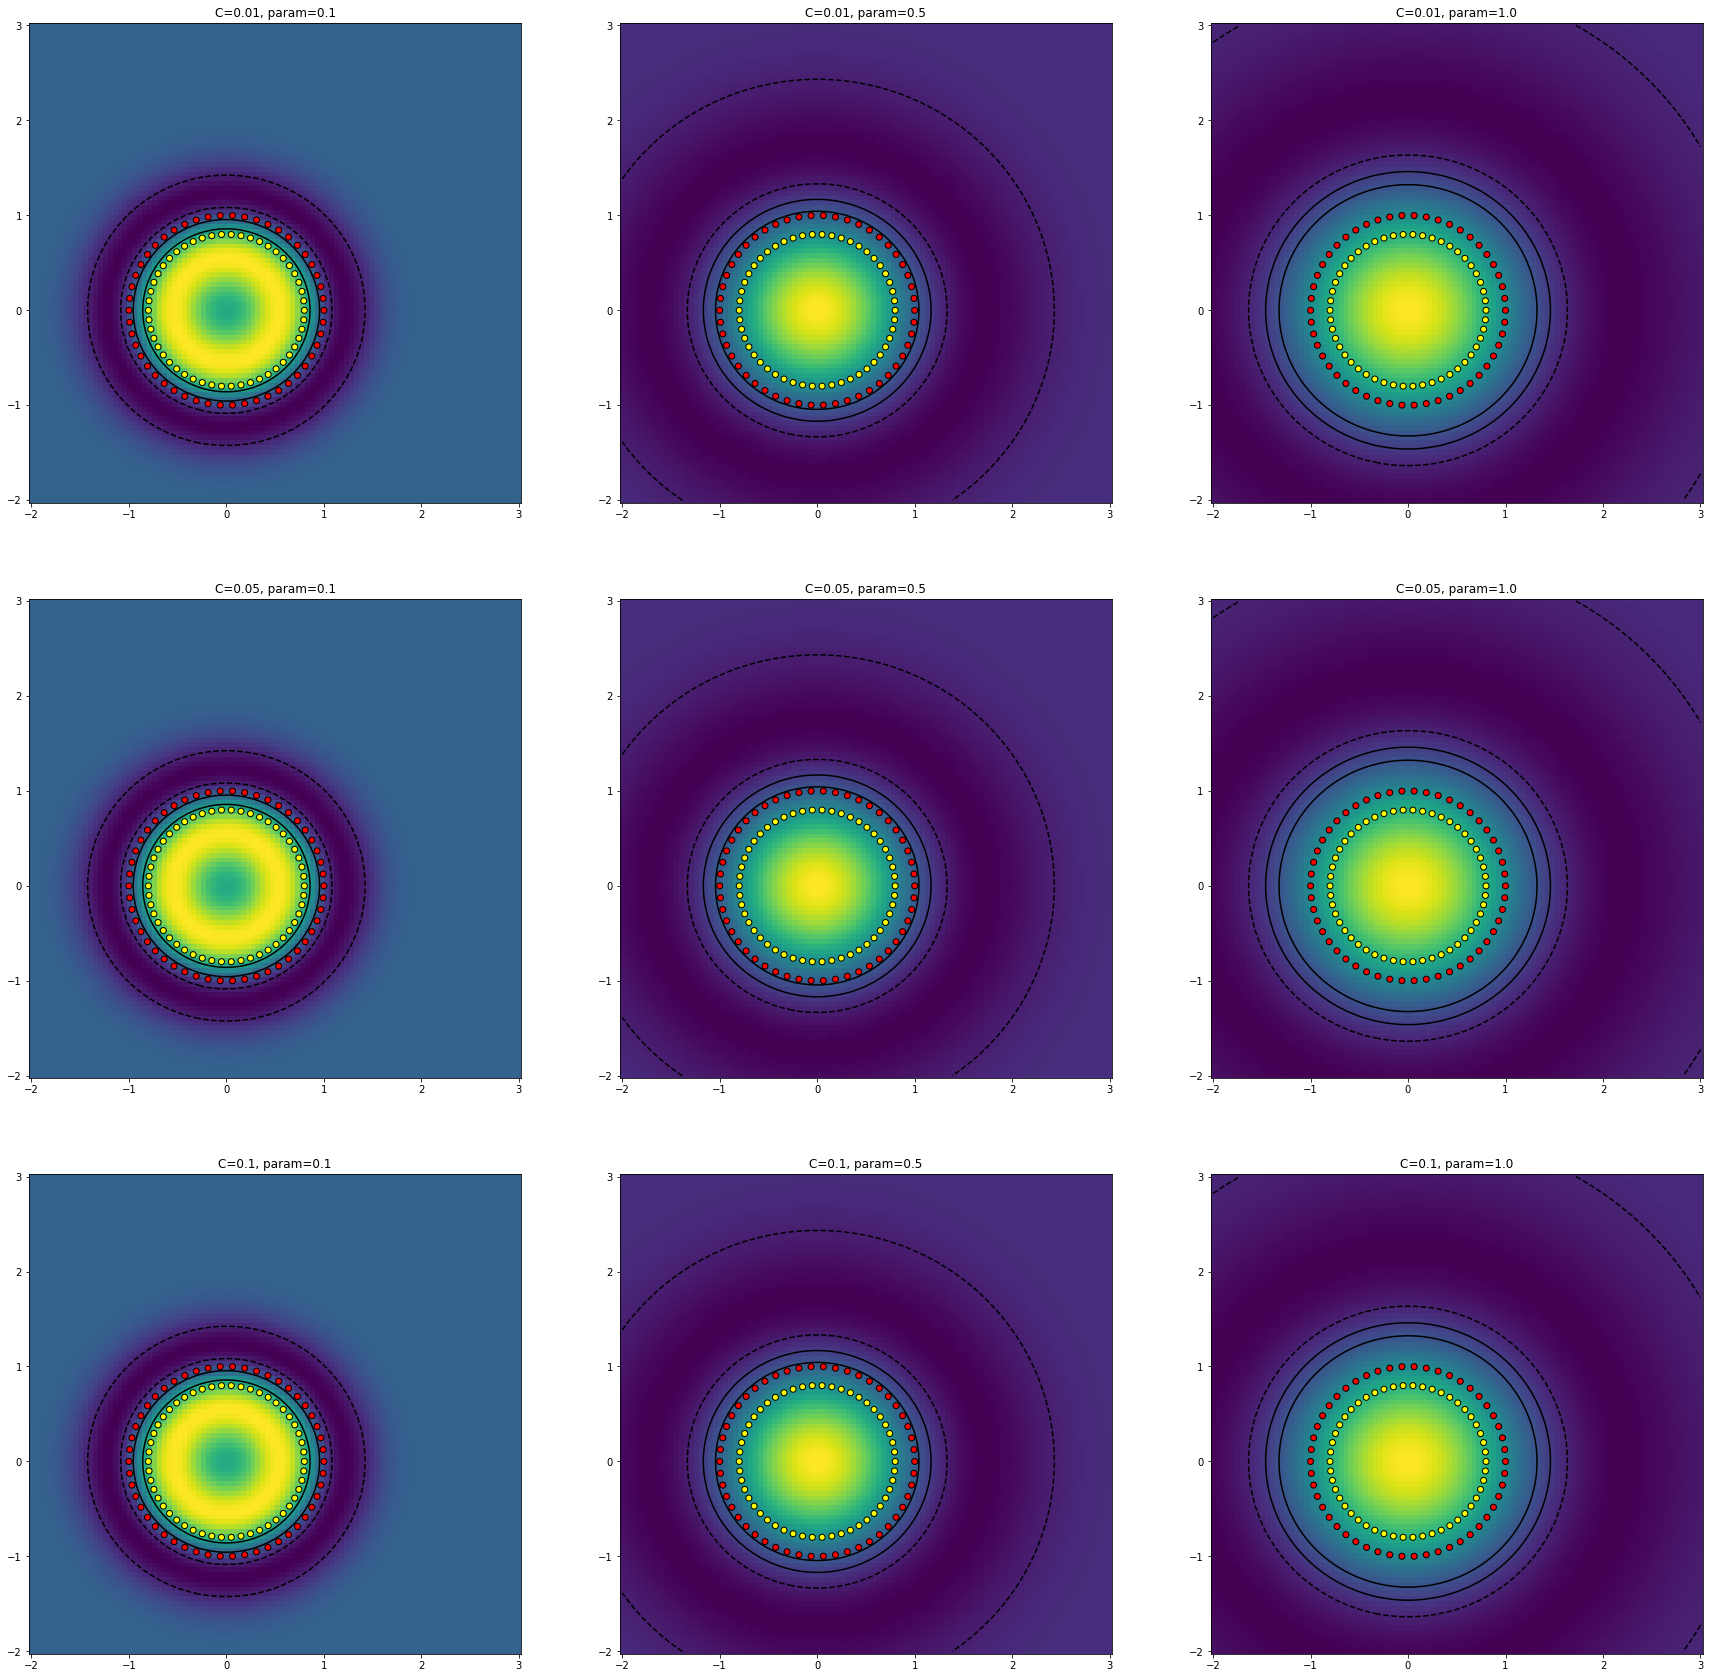

In [99]:
C_arr = np.array([0.01, 0.05, 0.1])
kappa_arr = np.array([0.1, 0.5, 1, 2])

fig, axs = plt.subplots(len(C_arr), len(p_arr))
fig.set_figheight(30)
fig.set_figwidth(30)

for i in range(len(C_arr)):
    for j in range(len(p_arr)):
        svm = SVM_Ker(C_arr[i], k_type='gaussian', gamma=kappa_arr[j])
        svm.fit(X_circle, y_circle)
        svm.show_results(axs[i, j])